### First of all, Why I Chose PyTorch over Keras

I decided to use **PyTorch** for this project instead of Keras, that we mainly used during lectures, due to the need for **fine-grained control**, **flexibility**, and a **research-friendly workflow** also most of the articles and blogs that I checked they used PyTorch.


| Feature                          | PyTorch                        | Keras                             |
|----------------------------------|----------------------------------|-------------------------------------|
| Custom training + evaluation     | Manual loop, full control        | Rigid `.fit()` and callback system  |
| Arbitrary dataset structure      | Simple with `Dataset` class      | Requires format wrangling           |
| Top-k accuracy + metrics         | Clean with `torch.topk()`        | Manual metric writing needed        |



### Step 1: Getting Everything Set Up from Google Drive
In this initial setup step, I'm:

**Mounting Google Drive** so I can access my datasets directly from Colab.  
**Unzipping two key ZIP files**:
- One with all the **video frame data** (`frames.zip`)
- Another with the **train/test split files** (`test_train_splits.zip`)

Then I'm extracting:
- All the frames to `/content/HMDB51_frames`
- All the split metadata to `/content/HMDB51_splits`
> why? because I found  out if I extracted my data to my colab, it works much faster but mind that if you reset your colab it will all disappear, so I had to save my models and whatever I need before resetting my colab.  

- Ignore the __MACOSX folder, it's just a hidden system folder that macOS automatically creates when you compress (zip) files using its built-in archiving utility, because I zipped my data before uploading it on my drive.

Finally, I print a preview of what’s inside just to make sure everything landed where it should.



In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_frames_path = '/content/drive/MyDrive/HMDB51/frames.zip'
zip_splits_path = '/content/drive/MyDrive/HMDB51/test_train_splits.zip'

# where to extract
frames_extract_path = '/content/HMDB51_frames'
splits_extract_path = '/content/HMDB51_splits'

# Unzip the frames
with zipfile.ZipFile(zip_frames_path, 'r') as zip_ref:
    zip_ref.extractall(frames_extract_path)

# Unzip the split files
with zipfile.ZipFile(zip_splits_path, 'r') as zip_ref:
    zip_ref.extractall(splits_extract_path)

# just to confirm contents
print("Frames directory sample:", os.listdir(frames_extract_path)[:5])
print("Splits directory sample:", os.listdir(splits_extract_path)[:5])


Mounted at /content/drive
Frames directory sample: ['__MACOSX', 'frames']
Splits directory sample: ['test_train_splits', '__MACOSX']


### Step 2: Inspecting the Dataset

In this part, I'm doing a bit of data housekeeping:

**Going through all action classes and their clips**  
Each clip lives in its own folder and contains frames in `.jpg` format.

**Counting:**
- How many classes I've got in total
- How many clips there are overall

**Tracking frame counts** per clip using a `defaultdict` to build a frame count distribution.

**Spotting clips that don’t have exactly 16 frames**  
If a clip has the wrong number of frames, I log it in `invalid_clips` for review — just the first 10, no one wants a print flood.

> It is true that I have already checked these when I extracted my frames but after uploading them on my drive and extracting them, sometimes it happened that some frames haven't showed up to my extracted folder.

End result? I know whether my dataset is clean or if there’s any dodgy data that needs fixing before training. Better safe than sorry.


In [2]:
from collections import defaultdict

frames_root = '/content/HMDB51_frames/frames'

total_classes = 0
total_clips = 0
frame_count_distribution = defaultdict(int)
invalid_clips = []

for class_name in os.listdir(frames_root):
    class_path = os.path.join(frames_root, class_name)
    if not os.path.isdir(class_path):
        continue
    total_classes += 1
    for clip_name in os.listdir(class_path):
        clip_path = os.path.join(class_path, clip_name)
        if not os.path.isdir(clip_path):
            continue
        frame_files = [f for f in os.listdir(clip_path) if f.endswith('.jpg')]
        count = len(frame_files)
        frame_count_distribution[count] += 1
        if count != 16:
            invalid_clips.append((class_name, clip_name, count))
        total_clips += 1

print(f"✅ Total classes: {total_classes}")
print(f"🎞️ Total clips: {total_clips}")
print(f"📊 Frame count distribution:")
for frame_count in sorted(frame_count_distribution.keys()):
    print(f"   {frame_count} frames → {frame_count_distribution[frame_count]} clips")

if invalid_clips:
    print(f"\n⚠️ Clips with incorrect frame count ({len(invalid_clips)} total):")
    for class_name, clip_name, count in invalid_clips[:10]:  # only show first 10 to avoid flooding
        print(f"   {class_name}/{clip_name} → {count} frames")
    if len(invalid_clips) > 10:
        print("   ... (more not shown)")
else:
    print("\n✅ All clips have exactly 16 frames.")


✅ Total classes: 51
🎞️ Total clips: 6766
📊 Frame count distribution:
   16 frames → 6766 clips

✅ All clips have exactly 16 frames.


### Step 3: Counting All Image Frames in the Dataset

**Looping through every clip in every class**, I’m tallying up **all the individual `.jpg` frames** in the dataset.

This gives me a proper sense of scale, how many total frames I’ve got to work with across all clips.


In [3]:
total_frames = 0

for class_name in os.listdir(frames_root):
    class_path = os.path.join(frames_root, class_name)
    if not os.path.isdir(class_path):
        continue
    for clip_name in os.listdir(class_path):
        clip_path = os.path.join(class_path, clip_name)
        if not os.path.isdir(clip_path):
            continue
        frame_files = [f for f in os.listdir(clip_path) if f.endswith('.jpg')]
        total_frames += len(frame_files)

print(f"🖼️ Total number of image frames in dataset: {total_frames}")


🖼️ Total number of image frames in dataset: 108256


### Step 4: Loading and Splitting the Dataset (Train / Val / Test)
This block handles the **official HMDB51 split files** and prepares my data for model training.

What’s going on here?

| Bit | What it does |
|-----|--------------|
| `glob()`  | Collects all split text files for a given split (e.g. `split1`) |
| `class_to_idx`  | Assigns a unique class index to each action class |
| `label == 1`  | Marks clips for training |
| `label == 2` | Marks clips for testing |
| `clip_path` | Checks if the extracted frame folder exists for the clip |
| `StratifiedShuffleSplit`  | Further splits the training set into train/validation — preserving class balance |

**Returns**:
- `train_list_final` → list of `(clip_path, class_index)` for training
- `val_list` → same format, for validation
- `test_list` → for final evaluation
- `class_to_idx` → dictionary mapping class names to indices

Final output confirms how many clips are in each split, and how many classes I’ve got.



In [ ]:
import os
from glob import glob
from sklearn.model_selection import StratifiedShuffleSplit

splits_root = '/content/HMDB51_splits/test_train_splits'
frames_root = '/content/HMDB51_frames/frames'

def load_hmdb51_split(split_number=1, val_ratio=0.1, seed=42):
    train_full = []
    test_list = []
    class_to_idx = {}

    split_files = sorted(glob(os.path.join(splits_root, f'*_test_split{split_number}.txt')))

    for i, split_file in enumerate(split_files):
        class_name = os.path.basename(split_file).split('_test_split')[0]
        class_to_idx[class_name] = i

        with open(split_file, 'r') as f:
            for line in f:
                vid_name, label = line.strip().split()
                label = int(label)
                vid_base = vid_name.replace('.avi', '')
                clip_path = os.path.join(frames_root, class_name, vid_base)

                if not os.path.isdir(clip_path):
                    continue  # skip if frames don't exist

                item = (clip_path, i)

                if label == 1:
                    train_full.append(item)
                elif label == 2:
                    test_list.append(item)

    # Stratified train/val split
    X = [x[0] for x in train_full]
    y = [x[1] for x in train_full]
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=seed)
    train_idx, val_idx = next(splitter.split(X, y))

    train_list_final = [(X[i], y[i]) for i in train_idx]
    val_list = [(X[i], y[i]) for i in val_idx]

    return train_list_final, val_list, test_list, class_to_idx

# Load everything for split 1
train_list_final, val_list, test_list, class_to_idx = load_hmdb51_split(split_number=1)

print(f" Split 1 processed with validation:")
print(f"   ➤ Train clips: {len(train_list_final)}")
print(f"   ➤ Val clips:   {len(val_list)}")
print(f"   ➤ Test clips:  {len(test_list)}")
print(f"   ➤ Total classes: {len(class_to_idx)}")


✅ Split 1 processed with validation:
   ➤ Train clips: 3213
   ➤ Val clips:   357
   ➤ Test clips:  1530
   ➤ Total classes: 51


### Step 5: Custom PyTorch VideoDataset Loader
This class handles **video clips as sequences of 16 frames** and applies smart augmentations and preprocessing to feed into my 3D CNN.

What this class is doing:

| Section | Purpose |
|--------|---------|
| `__init__`  | Sets up filepaths, defines transforms (basic and augmented) |
| `self.base_transform`  | Resize → CenterCrop → ToTensor (for clean evaluation) |
| `self.augment_transform` | RandomCrop, Flip, ColourJitter for stronger data augmentation during training |
| `__getitem__` | Loads 16 consecutive frames (with optional temporal jitter) and stacks them into a tensor |
| `torch.stack(..., dim=1)` | Converts list of frames → shape `[C, T, H, W]`, ready for 3D CNNs |

**Temporal Jitter**: Randomly selects the starting frame index to introduce temporal diversity, key to helping my model generalise over video time.

**Output**: A tensor clip of shape `[3, 16, 112, 112]` and its corresponding label.


In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import random
import os

class VideoDataset(Dataset):
    def __init__(self, clip_list, transform=None, augment=False):
        self.clip_list = clip_list
        self.transform = transform
        self.augment = augment

        self.base_transform = transforms.Compose([
            transforms.Resize((128, 171)),  # Resize to keep aspect ratio for center crop
            transforms.CenterCrop(112),
            transforms.ToTensor()
        ])

        self.augment_transform = transforms.Compose([
            transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.clip_list)

    def __getitem__(self, idx):
        clip_path, label = self.clip_list[idx]
        frame_files = sorted(os.listdir(clip_path))

        # Temporal jitter (random starting index or fixed)
        start_frame = 0
        if self.augment:
            max_start = max(0, len(frame_files) - 16)
            start_frame = random.randint(0, max_start)

        selected_frames = frame_files[start_frame:start_frame+16]
        clip = []

        for frame in selected_frames:
            frame_path = os.path.join(clip_path, frame)
            img = Image.open(frame_path).convert('RGB')
            if self.augment:
                img = self.augment_transform(img)
            else:
                img = self.base_transform(img)
            clip.append(img)

        clip = torch.stack(clip, dim=1)  # [C, T, H, W]
        return clip, label


### Step 6: Setting Up the Data Loaders

Now I'm feeding my dataset into PyTorch `DataLoader`s — the reliable delivery drivers of our training pipeline.

 **What’s going on:**

| Loader        | Purpose                                                                 |
|---------------|-------------------------------------------------------------------------|
| `train_loader` | Loads training clips with **augmentation** and **shuffling** — essential for learning general patterns |
| `val_loader` | Loads validation clips **without augmentation** to fairly evaluate performance |
| `test_loader` | Also without augmentation or shuffling — used for final accuracy checks |

**Key Parameters:**

- `BATCH_SIZE = 64` → balances training speed and GPU memory usage
- `shuffle=True` only for training, of course!
- `pin_memory=True` helps speed things up when using a CUDA device, just to make sure if my GPU is running. (*Using colab GPU was a real pain that I don't even wanna get into*)
- `num_workers=2` allows parallel data loading *(tweakable depending on my runtime, but don't let the name fool you, here is not the case of the more the merrier but if you got too many of worker they all gonna mess up, as it was advised on PyTorch doc I used just 2)*


In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = 2

train_dataset = VideoDataset(train_list_final, augment=True)
val_dataset = VideoDataset(val_list, augment=False)
test_dataset = VideoDataset(test_list, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders created:")
print(f"   ➤ Train: {len(train_loader)} batches")
print(f"   ➤ Val:   {len(val_loader)} batches")
print(f"   ➤ Test:  {len(test_loader)} batches")


✅ DataLoaders created:
   ➤ Train: 51 batches
   ➤ Val:   6 batches
   ➤ Test:  24 batches


### Step 7: Defining the Model – 3D CNN for Video Action Recognition

Why 3D CNN?

Videos have both **spatial** (height, width) and **temporal** (time) dimensions.
A regular 2D CNN only captures spatial features per frame — but a 3D CNN? It sees across **frames**, capturing **motion and sequence** natively.

So I’ve gone with a **3DCNN** — lightweight yet expressive enough for learning meaningful spatiotemporal patterns.

**Model Architecture Overview**

| Layer Block             | Details                                                                 |
|-------------------------|-------------------------------------------------------------------------|
| `Conv3D(3→64)`          | 3D convolution capturing low-level spatiotemporal features             |
| `BatchNorm3D`           | Normalises activations to stabilise and speed up training              |
| `ReLU`                  | Non-linearity to introduce learning capacity                           |
| `MaxPool3D(2x2x2)`      | Reduces spatial and temporal resolution (downsampling)                 |
| `Conv3D(64→128)`        | Learns more abstract temporal+spatial patterns                         |
| `BatchNorm3D` + `ReLU`  | Same as before                                                          |
| `MaxPool3D(2x2x2)`      | Further temporal/spatial downsampling                                  |
| `Conv3D(128→256)`       | Deeper layer capturing higher-order motion & texture cues              |
| `BatchNorm3D` + `ReLU`  | Again, normalisation and activation                                     |
| `AdaptiveAvgPool3D(1)`  | Collapses 3D spatial-temporal output to a flat feature vector (B, 256) |
| `Linear(256→num_classes)`| Final classifier over 51 action categories                            |

**Output**: Raw logits for 51 human action classes in HMDB51.

So it’s lean, fast, and hits all the right notes for an initial "try" on HMDB51.

Let’s get this model trained and see what it can do.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=51):
        super(Simple3DCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1))  
        )

        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


### Step 8: Training Setup — Loss, Optimizer, Scheduler, Early Stopping

**Training Configuration Overview**

| Component             | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `CrossEntropyLoss`    | Standard loss for multi-class classification — works on logits directly     |
| `Adam Optimizer`      | Adaptive gradient descent, works well with deep learning models              |
| `ReduceLROnPlateau`   | Monitors **validation loss**, reduces LR by factor of 0.5 if no improvement |
| `Early Stopping`      | Stops training after **5 epochs** of no validation accuracy improvement     |
| `CUDA or CPU`         | Automatically uses GPU if available                                          |
| `Model Checkpointing` | Best model saved to `checkpoints/best_3dcnn.pt` based on val accuracy        |

**Training History Logging**

I'm tracking:

- `train_loss` and `val_loss` — for monitoring overfitting/underfitting
- `train_acc` and `val_acc` — for performance tracking
- Best model = highest **validation accuracy**

All of this is wrapped in the `history` dict, making it easy to plot later or analyse across models.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from copy import deepcopy
from tqdm import tqdm

#  model, loss, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Simple3DCNN(num_classes=51).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# Early stopping setup with patience of 5
early_stop_patience = 5
best_val_loss = float('inf')
patience_counter = 0

os.makedirs("checkpoints", exist_ok=True)
best_model_path = "checkpoints/best_3dcnn.pth"

# Tracking metrics for later analysis 
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


### Step 9: Training Loop with Early Stopping, Scheduler, and Model Checkpointing


This is my full training loop running for up to 40 epochs (unless early stopping kicks in sooner, *spoiler : it will*). let's break it down:

---

### Epoch-wise Flow

| Stage             | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `model.train()`  | Sets the model to training mode (enables dropout, batchnorm etc.)            |
| Forward + Backward | The model predicts, computes loss (`CrossEntropy`), and backpropagates     |
| Accuracy          | Predictions are compared to true labels for accuracy                        |
| `model.eval()`   | Switches to evaluation mode for validation (disables dropout etc.)          |
| Scheduler         | `ReduceLROnPlateau` reduces LR if val loss stagnates for 2 epochs           |
| Checkpointing     | Saves the best model based on **validation loss**, not just accuracy        |
| Early Stopping    | If val loss doesn’t improve for 5 epochs, training is halted                |

---

### What do the printed results show?


- **Training Loss** steadily drops from `3.66` to around `2.64` — so the model is definitely learning
- **Training Accuracy** grows from `~6.9%` to `~30%` — promising trajectory
- **Validation Loss** jumps around a bit but shows periodic improvements
- **Validation Accuracy** starts low (`~4.4%`) but hits a peak of `~16.5%` at **Epoch 12**

Every time you see this:
> 💾 Best model saved to checkpoints/best_3dcnn.pth

…it means validation loss has improved — so the best performing model (so far) has just been saved.

Eventually, by **Epoch 17**, validation loss stops improving long enough to trigger:

> ⏹️ Early stopping triggered at epoch 17


---

### 📈 Summary of Progress So Far

| Metric              | Initial        | Best Achieved     | Epoch |
|---------------------|----------------|-------------------|-------|
| Train Accuracy       | 6.9%           | 30.2%             | 17    |
| Validation Accuracy  | 4.4%           | **16.5%**         | **12**|
| Best Val Loss        | 3.2811         | ✅ Model saved     | 12    |

---

### What could improve from here? (which I'm gonna do it on the next model)

- Add **Dropout layers** (if not already present) to reduce overfitting  
- Stronger **data augmentation** (temporal jitter, affine, brightness)  
- Consider **CosineAnnealingLR** for smoother LR decay  
- Increase **batch size** if memory allows — might stabilise validation  

-----

## Overfitting Analysis

Based on the training and validation performance across 17 epochs, we can conclude that **the model is overfitting**. Here's the evidence that supports this:

### 1. Training Loss vs Validation Loss
- **Training loss** consistently improves from `3.66 → 2.64`, indicating the model is fitting the training data well.
- **Validation loss**, however, is unstable. It initially improves slightly, but later fluctuates and even increases.
- This **divergence** between training and validation loss is a classic sign of overfitting that I'm gonna show it better on the next step with plotting.

### 2. Training Accuracy vs Validation Accuracy
- **Training accuracy** steadily increases from `6.9% → 30.2%`.
- **Validation accuracy** peaks at **16.5% (epoch 12)**, but then declines or fluctuates in the low teens, suggesting poor generalisation.

| Metric        | Epoch 1 | Epoch 12 (peak) | Epoch 17 |
|---------------|---------|------------------|----------|
| Train Acc     | 6.9%    | 26.2%            | 30.2%    |
| Val Acc       | 4.5%    | 16.5%            | 12.6%    |

### 3. Early Stopping Triggered
- Training was halted at **epoch 17** due to early stopping, after no validation improvement for several epochs.
- This confirms the model stopped learning *general features* and was likely memorising the training set.

---

> **The model is overfitting** — it's learning the training data too well but struggling to generalise to unseen validation data.

In the next stage "3DCNN-v22.0", I'm gonna set the goal to reduce overfitting and improve validation performance.



In [11]:
num_epochs = 40

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for clips, labels in tqdm(train_loader, desc="Training", leave=False):
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(clips)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * clips.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    net.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validating", leave=False):
            clips, labels = clips.to(device), labels.to(device)
            outputs = net(clips)
            loss = loss_fn(outputs, labels)

            val_running_loss += loss.item() * clips.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"📉 Train Loss: {train_loss:.4f} | 🟢 Train Acc: {train_acc:.4f}")
    print(f"📊 Val Loss:   {val_loss:.4f} | 🟡 Val Acc:   {val_acc:.4f}")

    # Check for best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(net.state_dict(), best_model_path)
        print(f"💾 Best model saved to {best_model_path}")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break



🔁 Epoch 1/40


📉 Train Loss: 3.6621 | 🟢 Train Acc: 0.0691
📊 Val Loss:   3.6436 | 🟡 Val Acc:   0.0448
💾 Best model saved to checkpoints/best_3dcnn.pth

🔁 Epoch 2/40


📉 Train Loss: 3.4599 | 🟢 Train Acc: 0.1027
📊 Val Loss:   3.6977 | 🟡 Val Acc:   0.0700

🔁 Epoch 3/40


📉 Train Loss: 3.3651 | 🟢 Train Acc: 0.1307
📊 Val Loss:   3.4560 | 🟡 Val Acc:   0.0980
💾 Best model saved to checkpoints/best_3dcnn.pth

🔁 Epoch 4/40


📉 Train Loss: 3.2725 | 🟢 Train Acc: 0.1534
📊 Val Loss:   3.4788 | 🟡 Val Acc:   0.1064

🔁 Epoch 5/40


📉 Train Loss: 3.2166 | 🟢 Train Acc: 0.1653
📊 Val Loss:   3.5085 | 🟡 Val Acc:   0.0924

🔁 Epoch 6/40


📉 Train Loss: 3.1518 | 🟢 Train Acc: 0.1690
📊 Val Loss:   3.3995 | 🟡 Val Acc:   0.1092
💾 Best model saved to checkpoints/best_3dcnn.pth

🔁 Epoch 7/40


📉 Train Loss: 3.0999 | 🟢 Train Acc: 0.1877
📊 Val Loss:   3.3305 | 🟡 Val Acc:   0.1092
💾 Best model saved to checkpoints/best_3dcnn.pth

🔁 Epoch 8/40


📉 Train Loss: 3.0512 | 🟢 Train Acc: 0.1995
📊 Val Loss:   3.8190 | 🟡 Val Acc:   0.1008

🔁 Epoch 9/40


📉 Train Loss: 3.0172 | 🟢 Train Acc: 0.2163
📊 Val Loss:   3.6548 | 🟡 Val Acc:   0.0980

🔁 Epoch 10/40


📉 Train Loss: 2.9693 | 🟢 Train Acc: 0.2135
📊 Val Loss:   3.4706 | 🟡 Val Acc:   0.1204

🔁 Epoch 11/40


📉 Train Loss: 2.8581 | 🟢 Train Acc: 0.2512
📊 Val Loss:   3.3577 | 🟡 Val Acc:   0.1373

🔁 Epoch 12/40


📉 Train Loss: 2.8190 | 🟢 Train Acc: 0.2621
📊 Val Loss:   3.2811 | 🟡 Val Acc:   0.1653
💾 Best model saved to checkpoints/best_3dcnn.pth

🔁 Epoch 13/40


📉 Train Loss: 2.7916 | 🟢 Train Acc: 0.2748
📊 Val Loss:   3.4420 | 🟡 Val Acc:   0.1176

🔁 Epoch 14/40


📉 Train Loss: 2.7673 | 🟢 Train Acc: 0.2667
📊 Val Loss:   3.8154 | 🟡 Val Acc:   0.1036

🔁 Epoch 15/40


📉 Train Loss: 2.7409 | 🟢 Train Acc: 0.2817
📊 Val Loss:   3.4667 | 🟡 Val Acc:   0.1345

🔁 Epoch 16/40


📉 Train Loss: 2.6805 | 🟢 Train Acc: 0.2891
📊 Val Loss:   3.3065 | 🟡 Val Acc:   0.1457

🔁 Epoch 17/40


📉 Train Loss: 2.6427 | 🟢 Train Acc: 0.3022
📊 Val Loss:   3.4722 | 🟡 Val Acc:   0.1261
⏹️ Early stopping triggered at epoch 17


## Test Set Evaluation

This block evaluates the **best saved model** on the **HMDB51 test set** using:

- **Top-1 Accuracy**: How often the model's top prediction matches the true label.
- **Top-5 Accuracy**: How often the true label is within the model's top 5 predictions.

### Results:
-  **Top-1 Accuracy**: `0.0928` (~9.3%)
-  **Top-5 Accuracy**: `0.3307` (~33.1%)

The model performs poorly on the test set, especially Top-1. This supports our earlier conclusion — **the model is overfitted**. It memorised training data but struggles to generalise.


In [12]:
import torch
import torch.nn.functional as F

# Load best model
net.load_state_dict(torch.load(best_model_path))
net.eval()

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Testing"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = net(clips)

        # Top-1
        _, pred_top1 = outputs.max(1)
        top1_correct += pred_top1.eq(labels).sum().item()

        # Top-5
        top5_vals, pred_top5 = outputs.topk(5, dim=1)
        top5_correct += sum([label in pred for label, pred in zip(labels, pred_top5)])

        total += labels.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"\n✅ Test Results:")
print(f"🎯 Top-1 Accuracy: {top1_acc:.4f}")
print(f"🥇 Top-5 Accuracy: {top5_acc:.4f}")


Testing: 100%|██████████| 24/24 [00:53<00:00,  2.24s/it]


✅ Test Results:
🎯 Top-1 Accuracy: 0.0928
🥇 Top-5 Accuracy: 0.3307


## Model Summary – 3D CNN Architecture (from `torchsummary`)

I'am using a straightforward but solid 3D CNN designed for processing short video clips (16 frames of size 112×112). The summary breaks down the model as follows:

### Architecture Breakdown:

- **Input shape**: `(3, 16, 112, 112)` → 3 colour channels, 16 frames, 112×112 resolution.
- **Convolutional Stack**:
  - Three main `Conv3D` layers:
    - First layer expands to 64 channels, keeping temporal resolution.
    - Followed by two more conv layers that increase channels to 128 and then 256, with spatial and temporal downsampling through `MaxPool3d`.
  - Each conv layer is followed by `BatchNorm3d` and `ReLU` for stability and non-linearity.
- **Pooling**:
  - After the convolutions, I apply `AdaptiveAvgPool3d` to compress the feature volume to `(1, 1, 1)` per channel.
- **Classifier**:
  - A fully connected `Linear` layer maps the final 256 feature vector to the 51 output classes.

### Parameter & Memory Info:

- **Total Parameters**: `1,125,555` — all trainable.
- **Memory Footprint**:
  - **Input**: 2.30MB
  - **Forward/Backward activations**: 401.19MB
  - **Model parameters**: 4.29MB
  - **Estimated Total**: ~408MB per sample (batch not included).



In [14]:
from torchsummary import summary
summary(net, input_size=(3, 16, 112, 112))  # (C, T, H, W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 16, 112, 112]           5,248
       BatchNorm3d-2     [-1, 64, 16, 112, 112]             128
              ReLU-3     [-1, 64, 16, 112, 112]               0
         MaxPool3d-4        [-1, 64, 8, 56, 56]               0
            Conv3d-5       [-1, 128, 8, 56, 56]         221,312
       BatchNorm3d-6       [-1, 128, 8, 56, 56]             256
              ReLU-7       [-1, 128, 8, 56, 56]               0
         MaxPool3d-8       [-1, 128, 4, 28, 28]               0
            Conv3d-9       [-1, 256, 4, 28, 28]         884,992
      BatchNorm3d-10       [-1, 256, 4, 28, 28]             512
             ReLU-11       [-1, 256, 4, 28, 28]               0
AdaptiveAvgPool3d-12         [-1, 256, 1, 1, 1]               0
           Linear-13                   [-1, 51]          13,107
Total params: 1,125,555
Trainable param

## Training & Validation Curves – Signs of Overfitting

The plotted training curves give us a clear window into how our model's learning process unfolded over time:

### What the Plots Show:

- **Accuracy Plot**:
  - Training accuracy steadily climbs — lovely.
  - Validation accuracy plateaus early and then stalls, or worse, drops. That's your first red flag. 🚩

- **Loss Plot**:
  - Training loss keeps falling nicely (as expected).
  - Validation loss, on the other hand, starts to increase after a certain point. That divergence? Classic overfitting.


This behaviour indicates that the model is learning the training data too well — memorising rather than generalising. It's not adapting well to unseen validation data, which means it’s starting to "overfit" the training distribution.

As we talked about this issue with Prof. Naploteno, the distance between train line and val line should be really near each others and if they are far apart that shows over fitting.


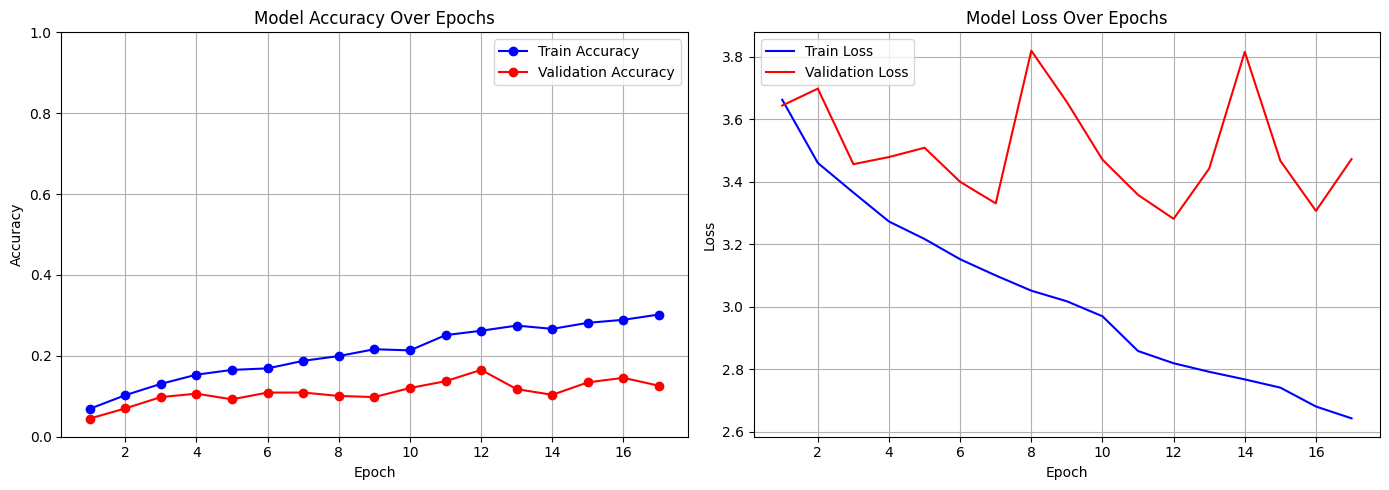

In [ ]:
import matplotlib.pyplot as plt

# Epoch range
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
